# Table of Contents   
## 1. [Imports](#Imports)
## 2. [Load Dataset](#Load-Dataset)
## 3. [Model Building](#Model-Building)
## 4. [Verbose Functions](#Verbose-Functions)
## 4. [Training Function](#Training-Function)
## 5. [Training](#Training)
## 6. [Results Analysis](#Results-Analysis)

# Imports

In [1]:
import torch
import copy
import numpy as np
import random
from matplotlib import pyplot as plt
import os
import sys
import csv

In [2]:
import torch.nn.functional as F
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.transforms.functional as torchvision_F
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm.auto import tqdm
from typing import Dict

In [3]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# import sys
# import os
# import shutil
# import warnings

# folder = "/content/gdrive/MyDrive/prune_Q" #@param {type:"string"}


# !ln -Ts $folder /content/prune_Q 2> /dev/null


# if '/content/prune_Q' not in sys.path:
#     sys.path.insert(0, '/content/prune_Q')



Mounted at /content/gdrive


In [ ]:
if 'prune_Q' not in sys.path:
    sys.path.insert(0, 'prune_Q')

In [4]:
from prune_Q import *

# Load Dataset

In [5]:
Seed = 6310
torch.manual_seed(Seed)
np.random.seed(Seed)
random.seed(Seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(Seed)
    torch.cuda.manual_seed_all(Seed)

# Model Building

In [13]:
train_loader, test_loader, calibration_loader = load_CIFAR10_dataset(batch_size=256, calibration_batch_size=1024)
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
train_loader = [(images.to(device), labels.to(device)) for images, labels in train_loader]
test_loader = [(images.to(device), labels.to(device)) for images, labels in test_loader]

Files already downloaded and verified
Files already downloaded and verified


# Verbose Functions

In [7]:
def get_ratio(prune_ratio_dict, full_size_dict):
    r = 0
    s = 0
    for k, v in prune_ratio_dict.items():
        r += (1-v) * full_size_dict[k]
        s += full_size_dict[k]
    return r/s

def get_prune_ratios(model):
    prune_ratio_dict = {}
    for name, m in model.named_modules():
        if isinstance(m, nn.Conv2d):
            prune_ratio_dict[name] = (((m.attention.cpu() <10**-4) & (m.attention.cpu() >-10**-4)).sum()/m.attention.shape[0]).item()
    return prune_ratio_dict

In [8]:
# Color Format
class Color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'


def c_format(s, *c):
    _c = reduce(lambda a,b:a+b, c)
    return _c+str(s)+Color.END

# Training Function

In [9]:
#Training function
def train(model, train_loader, criterion, l_w, l_att, alpha_att, optimizer, optimizer_att,scheduler, update_attention):
    for inputs, targets in train_loader:
        model.train()
        optimizer.zero_grad()
        optimizer_att.zero_grad()

        # Inference
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # weight regularization
        reg_w = torch.tensor(0., requires_grad=True)
        for name, param in model.named_parameters():
            if 'attention' not in name:
                reg_w = reg_w + torch.norm(param, 2)
        reg_w = reg_w*l_w

        # Attention regularization
        reg_att = torch.tensor(0., requires_grad=True)
        for name, m in model.named_modules():
            if isinstance(m, nn.Conv2d):
                reg_att = reg_att + l_att*(torch.norm(m.attention, 2) * (1 - alpha_att) + torch.norm(m.attention, 1) * alpha_att)
        # Total loss
        total_loss = loss + reg_w + reg_att

        # Backpropagation
        total_loss.backward()

        # Update optimizer and LR scheduler
        optimizer.step()
        if scheduler:
            scheduler.step()

        # Update attention values every few epochs
        if update_attention:
            optimizer_att.step()


# Training

In [10]:
# Folder to store training Data
folder = '/Saved' #@param {type:"string"}

In [14]:
Seed = 6310
torch.manual_seed(Seed)
np.random.seed(Seed)
random.seed(Seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(Seed)
    torch.cuda.manual_seed_all(Seed)

# Load Model
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
model_ = resnet32(pretrained=True, save_path='./save/').to(device)


# Quantize Model
method='sym'
act_N_bits=8
weight_N_bits=8
model = model_to_quant(model_, calibration_loader, act_N_bits, weight_N_bits,method, device)

# Weights of each layer in full model
full_size_dict = {}
for name, m in model.named_modules():
  if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
    full_size_dict[name] = np.array(m.weight.shape).prod()


# Hyperparameters
criterion = nn.CrossEntropyLoss()
att_epochs = 60
max_lr = 0.0001
max_lr_att = 0.0005  #it's not worth to increase this too much, accuracy penalty is a huge// Converged size gets smaller
l_w, l_att = 0.001, 0.05     #l_att has a drastic effect sparsity attention sharp increase
alpha_att = 0.8 #the closer to 1, the more L1 norm is used


# Maximum Recovery epochs
X = 6
Y = 8

# Thershold to increase Maximum recovery epochs from X to Y
threshold = 0.5 * att_epochs


# Generate timestamp for the file name
# timestamp = datetime.now().strftime("%Y%m%d%H%M%S")

# Define CSV files To Store training Data
csv_file_name = f"{folder}/data_W{weight_N_bits}A{act_N_bits}.csv"
prune_file_name = f"{folder}/prune_ratio_W{weight_N_bits}A{act_N_bits}.csv"
header = list(full_size_dict.keys()) + ['epoch_num']

with open(csv_file_name, 'a') as file:
    file.write(f"epoch,train_acc,test_acc,sparsity,update_attention\n")

with open(prune_file_name, mode='a', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=header)
    writer.writeheader()

# Parameters and Optimizers
model_param = [p for name, p in model.named_parameters() if "attention" not in name]
attention_param = [p for name, p in model.named_parameters() if "attention" in name]
optimizer = torch.optim.Adam(model_param, lr=max_lr, weight_decay=0)
optimizer_att = torch.optim.Adam(attention_param, lr=max_lr_att, weight_decay=0)
scheduler =None # torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=num_epochs, steps_per_epoch=len(train_loader))
scheduler_att = None

train_accuracy_list = []
test_accuracy_list = []
prune_ratios_list = []

# Training


# att_epochs = 20
epoch_num = 0
moving_avg_acc = [93]
for att_epoch in tqdm(range(att_epochs), desc="fit", leave=False):

    # setting Maximum recovery epochs
    if att_epoch < threshold:
        num_sub_epochs = X
    else:
        num_sub_epochs = Y

    acc = []

    for sub_epoch in range(num_sub_epochs):
        epoch_num += 1

        # Update Attention Values only on the first Recovery Epoch
        if sub_epoch == 0:
            update_attention = True
            print(c_format("Attention Update Sub-epoch", Color.BOLD,Color.PURPLE))
        else:
            update_attention = False
        train(model, train_loader, criterion, l_w, l_att, alpha_att, optimizer, optimizer_att,scheduler, update_attention)

        # Evaluation
        train_accuracy = evaluate(model, train_loader, device)
        test_accuracy = evaluate(model, test_loader, device)

        prune_dict = get_prune_ratios(model)
        prune_ = prune_dict.values()
        ratio = get_ratio(prune_dict,full_size_dict)


        train_accuracy_list.append(train_accuracy)
        test_accuracy_list.append(test_accuracy)
        prune_ratios_list.append(ratio)
        acc.append(test_accuracy)

        moving_avg_threshold = sum(moving_avg_acc[-3:])/len(moving_avg_acc[-3:])
        print("moving_avg_threshold", moving_avg_threshold)

        # Printing metrics

        print("epoch", c_format(epoch_num, Color.BOLD,Color.RED), ": train_accuracy=", c_format(train_accuracy, Color.BOLD,Color.GREEN), " test_accuracy=",c_format(test_accuracy, Color.BOLD,Color.GREEN))
        print("Channel stats ", prune_)
        print("Ratio: ",c_format(ratio, Color.BOLD,Color.CYAN))



        with open(csv_file_name, 'a') as file:
            file.write(f"{epoch_num},{train_accuracy},{test_accuracy},{ratio},{update_attention}\n")


        with open(prune_file_name, mode='a', newline='') as file:
            writer = csv.DictWriter(file, fieldnames=header)
            prune_dict['epoch_num'] = epoch_num
            writer.writerow(prune_dict)
        if test_accuracy >= moving_avg_threshold or train_accuracy == 100.0:
          break
    moving_avg_acc.append(max(acc))

fit:   0%|          | 0/60 [00:00<?, ?it/s]

Attention Update Sub-epoch
moving_avg_threshold 93.0
epoch 1 : train_accuracy= 99.96114349365234  test_accuracy= 92.81999206542969
Channel stats  dict_values([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
Ratio:  1.0
moving_avg_threshold 93.0
epoch 2 : train_accuracy= 99.9918212890625  test_accuracy= 92.95999908447266
Channel stats  dict_values([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
Ratio:  1.0
moving_avg_threshold 93.0
epoch 3 : train_accuracy= 100.0  test_accuracy= 93.28999328613281
Channel stats  dict_values([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
Ratio:  1.0
Attention Update Sub-epoch
moving_avg_threshold 93.14499

# Store Final Model

In [15]:
model_file_name = f"model_W{weight_N_bits}A{act_N_bits}.pth"
model_path = f'{folder}/{model_file_name}'
torch.save(model.state_dict(), model_path)

# Results Analysis

In [25]:
import pandas as pd
df_acc = pd.read_csv(csv_file_name,skiprows=3)
df_acc['prune_ratio'] = 1 - df_acc['sparsity']
# df_acc = df_acc[df_acc.update_attention != True]
df_acc['recovery_acc'] = list(df_acc['update_attention'])[1:] + [True]
df = pd.read_csv(prune_file_name,skiprows=3)
df = df.iloc[:,:-2]

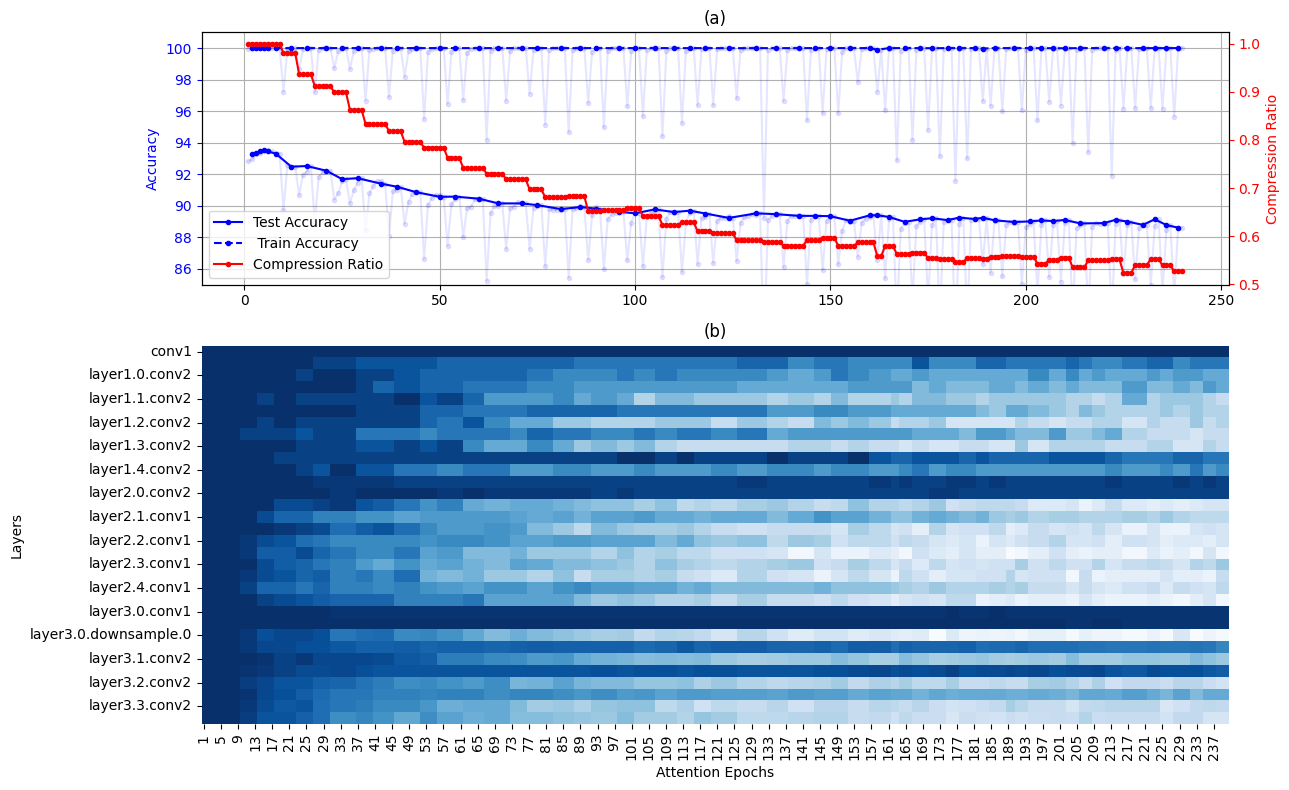

In [26]:
import seaborn as sns
fig, ax = plt.subplots(2,1,figsize=(13, 8),gridspec_kw={'height_ratios': [2, 3]})



# Plot the first line with the first y-axis
ax[0].plot(df_acc.epoch, df_acc.test_acc, 'b-', label='Test Accuracy', marker='.', alpha=0.1)

ax[0].plot(df_acc.epoch, df_acc.train_acc, 'b-', label='Train Accuracy', marker='.', alpha=0.1)
ax[0].plot(df_acc[df_acc['recovery_acc']].index, df_acc[df_acc['recovery_acc']].test_acc, 'b-', label='Test Accuracy', marker='.')
ax[0].plot(df_acc[df_acc['recovery_acc']].index, df_acc[df_acc['recovery_acc']].train_acc, 'b--', label=' Train Accuracy', marker='.',)

ax[0].set_xlabel('')
ax[0].set_ylabel('Accuracy', color='b')
ax[0].set_ylim([85,101])
ax[0].tick_params('y', colors='b')
ax[0].grid(True)

# Create the second axis that shares the same x-axis
ax2 = ax[0].twinx()

# Plot the second line with the second y-axis
ax2.plot(df_acc.epoch, df_acc.sparsity, 'r-', label='Compression Ratio', marker='.')
ax2.set_ylabel('Compression Ratio', color='r')
ax2.tick_params('y', colors='r')



lines1, labels1 = ax[0].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax[0].legend(lines[2:], labels[2:], loc='lower left')



ax[0].set_title('(a)')



df2 = df
df2.index = df_acc.epoch
mask = np.array(df2.iloc[:,:-1].T==1)

annot_data = np.array([['100%' if mask[i,j] else '' for j in range(mask.shape[1])] for i in range(mask.shape[0])])

axx = sns.heatmap(df2.iloc[:,:-1].T, fmt='', cmap='Blues_r', cbar=False, annot=annot_data, ax=ax[1])



ax[1].set_title("(b)")
ax[1].set_xlabel("Attention Epochs")
ax[1].set_ylabel("Layers")
fig.tight_layout()
fig.savefig("pl2.png",dpi=200)

In [34]:
import plotly.graph_objects as go



df_acc2 = df_acc[df_acc['recovery_acc']]
fig = go.Figure()
# Add traces for each y-axis
fig.add_trace(go.Scatter(x=df_acc['epoch'], y=df_acc['test_acc'], opacity=0.2,name='Test Accuracy', yaxis='y', line=dict(color='blue', width=1), marker=dict(symbol='circle', size=5), mode="lines+markers"))
fig.add_trace(go.Scatter(x=df_acc['epoch'], y=df_acc['train_acc'], opacity=0.2,name='Train Accuracy', yaxis='y', line=dict(color='blue', width=1, dash='dot'), marker=dict(symbol='circle', size=5), mode="lines+markers"))
fig.add_trace(go.Scatter(x=df_acc['epoch'], y=df_acc['sparsity'], name='Compression Ratio', yaxis='y2',line=dict(color='red', width=1), marker=dict(symbol='circle', size=5), mode="lines+markers"))
fig.add_trace(go.Scatter(x=df_acc2['epoch'], y=df_acc2['test_acc'], name='Test Accuracy', yaxis='y', line=dict(color='blue', width=1), marker=dict(symbol='circle', size=5), mode="lines+markers"))
fig.add_trace(go.Scatter(x=df_acc2['epoch'], y=df_acc2['train_acc'], name='Train Accuracy', yaxis='y', line=dict(color='blue', width=1, dash='dot'), marker=dict(symbol='circle', size=5), mode="lines+markers"))

# Update layout to include secondary y-axis
fig.update_layout(title='Compression Ratio and Train and Test Accuracies with Epochs',
                  yaxis=dict(title='Accuracy', side='left', showgrid=False),
                  xaxis={'title':"Epochs"},
                  yaxis2=dict(title='Compression Ratio', side='right', overlaying='y', showgrid=False), height=600, width=1000,title_x=0.5,
                  title_font=dict(size=24),  # Increase title font size
                  font=dict(size=16),  # Increase axis titles and legend font size
                  legend=dict(font=dict(size=14)))

# Show the plot
fig.show()

In [28]:
def get_pareto_front(df):
    pareto_front = []

    for idx, row in df.iterrows():
        is_dominated = False
        for _, comp_row in df.iterrows():
            if not (row == comp_row).all():
                dominates = all(row <= comp_row) and any(row < comp_row)
                if dominates:
                    is_dominated = True
                    break
        if not is_dominated:
            pareto_front.append(row)

    return pd.DataFrame(pareto_front, columns=df.columns)

In [29]:
index = get_pareto_front(df_acc[['test_acc', 'prune_ratio']]).index
test_acc = df_acc.loc[index, 'test_acc']
# size = df_acc.loc[index, 'size']
sparsity = df_acc.loc[index, 'sparsity']

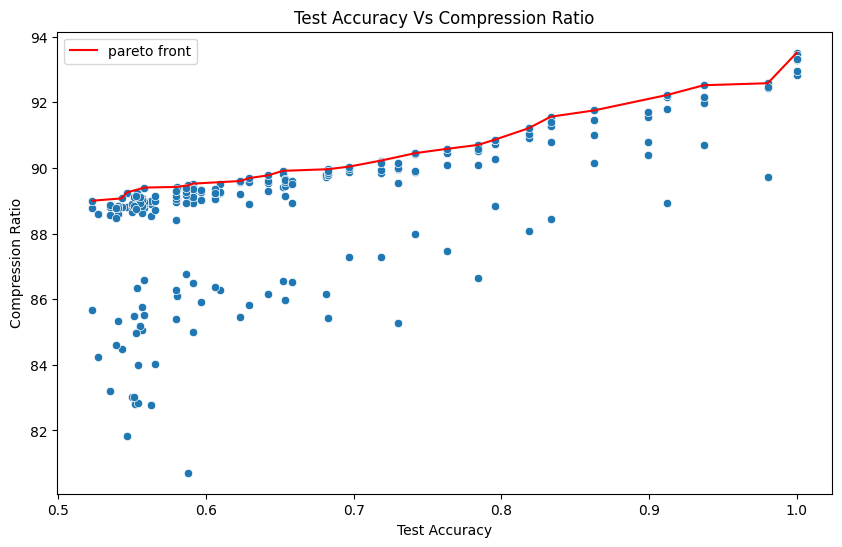

In [32]:
plt.figure(figsize=(10,6))
sns.scatterplot(df_acc, y='test_acc', x='sparsity')
sns.lineplot(y=test_acc, x=sparsity, label="pareto front", color='r')
plt.xlabel("Test Accuracy")
plt.ylabel("Compression Ratio")
plt.title("Test Accuracy Vs Compression Ratio")
plt.show()

In [35]:
import plotly.express as px


fig = px.scatter(df_acc, y='test_acc', x='sparsity')
fig.add_scatter(y=test_acc.sort_values(), x=sparsity.sort_values(), mode='lines+markers', name='Pareto Front')
fig.update_layout(title="Compression Ratio % Vs Test Accuracy %",
                  yaxis={'title':'Test Accuracy'},
                  xaxis={'title':'Compression Ratio'},
                  title_x=0.5)